In [1]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os

from earthpy.spatial import stack as es_stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean

# mapping
import cartopy
import cartopy.crs as ccrs


from matplotlib import colors

import pandas as pd

import calendar

from pylab import *
rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import imageio # animation

In [44]:
# get coords
## try for my data
def plot_max_month(argm_data, raster_folder, title=None):
    
    # make a color map of fixed colors
    cmap = colors.ListedColormap(['#1a68d6', # January (dark blue)
                                  '#5713bd', # February (purplish)
                                  '#8ee3fa', # March (light blue)
                                  '#e3df10', # April (yellow)
                                  '#fa6969', # May (light red)
                                   '#d8e3e1', # June (off white)
                                   '#a30000', # July (dark red)
                                   '#74c477', # August (light green)
                                   '#8a4300', # September (dark brown)
                                   '#fa7d07', # October (brighter orange)
                                   '#006c75', # November (darker tealish)
                                   '#00ebff']) # December (light blue)

    tick_labels = ['Jan',
                  'Feb',
                  'Mar',
                  'Apr',
                  'May',
                  'Jun',
                  'Jul',
                  'Aug',
                  'Sep',
                  'Oct',
                  'Nov',
                  'Dec']

    bounds=[0.5,1.5,2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)


    data=argm_data
    agg_fact=1
    template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
    with rio.open(template) as src:
        meta = src.meta

    tform = meta['transform']
    #num_x = meta['width']
    #num_y = meta['height']

    num_x = data.shape[1]
    num_y = data.shape[0]

    # incorporate aggregation factor
    tlon = np.linspace(tform.c - tform.a*agg_fact, tform.c+num_x*tform.a*agg_fact, num_x)
    tlat = np.linspace(tform.f - tform.e*agg_fact, tform.f+num_y*tform.e*agg_fact, num_y)
    lon2d, lat2d = np.meshgrid(tlon, tlat)


    # make data into xarray with location
    xdata = xr.DataArray(data, coords=[tlat, tlon], dims=['lat', 'lon'])
    xdata = xr.where(xdata == 0, np.nan, xdata)

    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.EqualEarth())
    ax.set_global()
    ax.coastlines()
    ax.gridlines()
    img = xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
    cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=np.array(bounds)-0.5)
    cbar.ax.set_yticklabels(tick_labels)
    plt.title(title)
    plt.show()
    
    # Used to return the plot as an image array
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image
    
    
def get_fire_year_files(raster_folder, var, year):
    
    yr_mos = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    yr_mos_p1 = ['January', 'February']

    # extract rasters for a single fire year, defined as March to February of following year.
    day_files = glob(raster_folder + f'{var}/*_D_*_{year}*')
    day_files = [f for f in day_files if os.path.basename(f).split('_')[4] in yr_mos]
    day_files2 = glob(raster_folder + f'{var}/*_D_*_{year+1}*')
    day_files2 = [f for f in day_files2 if os.path.basename(f).split('_')[4] in yr_mos_p1]
    day_files_yr = day_files + day_files2

    # night_files
    night_files = glob(raster_folder + f'{var}/*_N_*_{year}*')
    night_files = [f for f in night_files if os.path.basename(f).split('_')[4] in yr_mos]
    night_files2 = glob(raster_folder + f'{var}/*_N_*_{year+1}*')
    night_files2 = [f for f in night_files2 if os.path.basename(f).split('_')[4] in yr_mos_p1]
    night_files_yr = night_files + night_files2
    
    month_vals = dict((v,k) for k,v in enumerate(calendar.month_name))
    month_names = [os.path.basename(f).split('_')[4] for f in day_files_yr]

    # get the way things are sorted
    cur_sort = [month_vals[m] for m in month_names] 
    cur_sort_inds = np.array(cur_sort)

    # should be sorted as 
    fy_sort = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
    fy_sort_inds = np.array(fy_sort)

    if len(fy_sort) > len(cur_sort):
        # this would happen if the current year data is provisional and doesn't have the fields!
        fy_sort = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        fy_sort_inds = np.array(fy_sort)
    
    temp_df = pd.DataFrame({'files': day_files_yr, 'cur_ind':cur_sort_inds, 'fy_ind': fy_sort_inds, 'dummy': 'blah'})

    # sort correctly for FY
    df1 = temp_df.set_index('cur_ind')
    df1 = df1.reindex(index=fy_sort_inds)
    df1.reset_index();

    temp_df = pd.DataFrame({'files': night_files_yr, 'cur_ind':cur_sort_inds, 'fy_ind': fy_sort_inds, 'dummy': 'blah'})

    # sort correctly for FY
    df2 = temp_df.set_index('cur_ind')
    df2 = df2.reindex(index=fy_sort_inds)
    df2.reset_index();
    
    return df1.files, df2.files

def nanargmax(files, nodataval=-32768):

    # stack one
    test_arr,_ = es_stack(files, nodata=nodataval)

    # mask the nodata
    ma = np.ma.masked_equal(test_arr, nodataval)
    #ma = np.ma.filled(ma, np.nan)
    all_na_mask = np.any(ma, axis=0)

    # get the argmax
    argm = np.argmax(test_arr, axis=0) + 1
    argm = np.ma.masked_less(argm, -np.inf)
    argm.mask = ~all_na_mask
    
    return argm

In [3]:
raster_folder = r"../vars/grid_0_25_degree_vars/" # data refresh!
raster_folder = r"../vars/grid_2_5_degree_vars/" # data refresh!
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]
year = 2012

day_files, night_files = get_fire_year_files(raster_folder, var, year)

In [4]:
# verify
for fi in day_files:
    print(fi)
    
print()

# verify
for fi in night_files:
    print(fi)

../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_March_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_April_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_May_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_June_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_July_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_August_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_September_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_October_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_November_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_December_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_January_2013.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_D_AFC_num_February_2013.tif

../vars/grid_2_5_degree_vars/AFC_num\modis_N_AFC_num_March_2012.tif
../vars/grid_2_5_degree_vars/AFC_num\modis_N_AFC_num_April_2012.tif
../vars/grid_2_5_degree_vars/AFC_

In [5]:
day_argmax = nanargmax(day_files)
night_argmax = nanargmax(night_files)


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


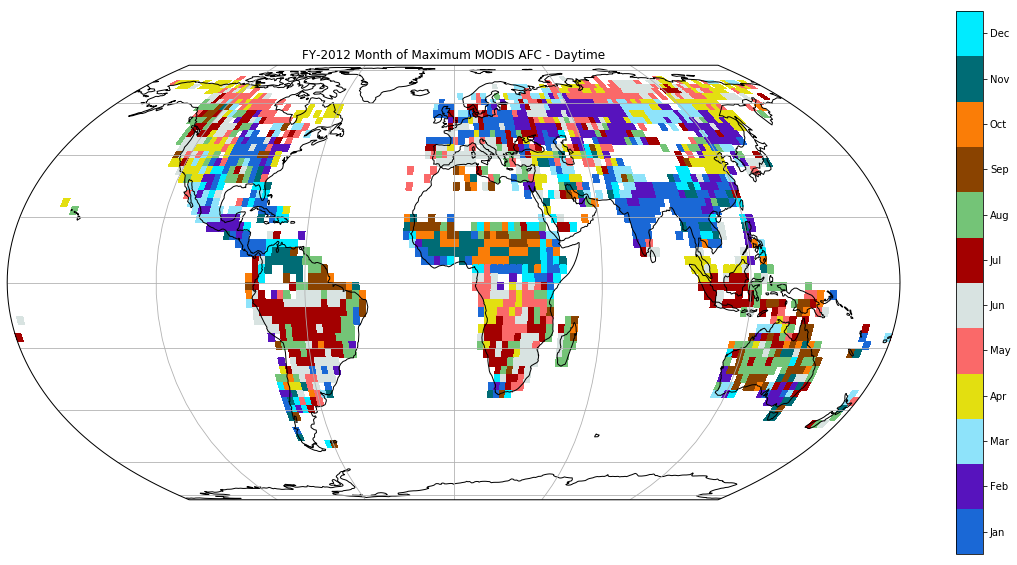

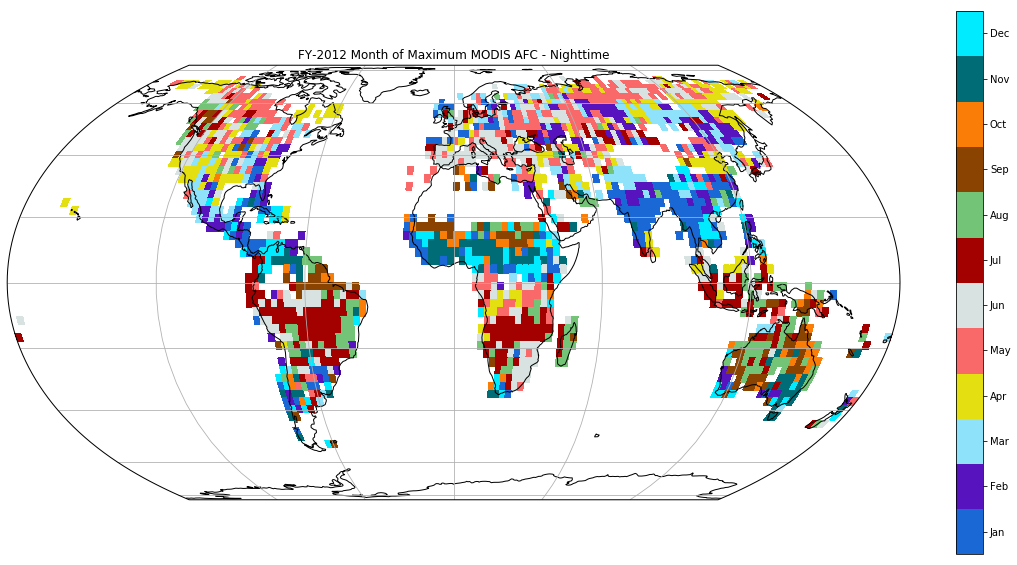

In [6]:
day_title = 'FY-{} Month of Maximum MODIS AFC - Daytime'.format(year)
plot_max_month(day_argmax, raster_folder, day_title)
night_title = 'FY-{} Month of Maximum MODIS AFC - Nighttime'.format(year)
plot_max_month(night_argmax, raster_folder, night_title)

# checking to make sure the data is indeed different for day/night

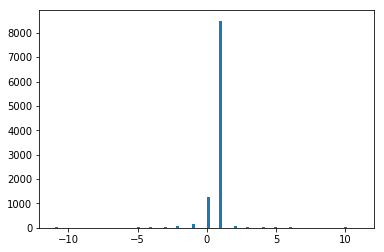

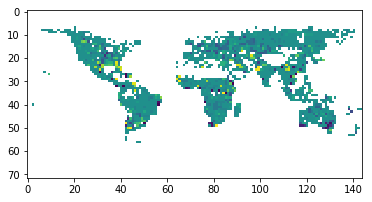

In [12]:
plt.hist(day_argmax.flatten() - night_argmax.flatten(), bins=100);
plt.show()
plt.imshow(day_argmax - night_argmax);

In [8]:
np.mean(day_argmax.flatten() - night_argmax.flatten())

-0.15995975855130784

# iterate over some years

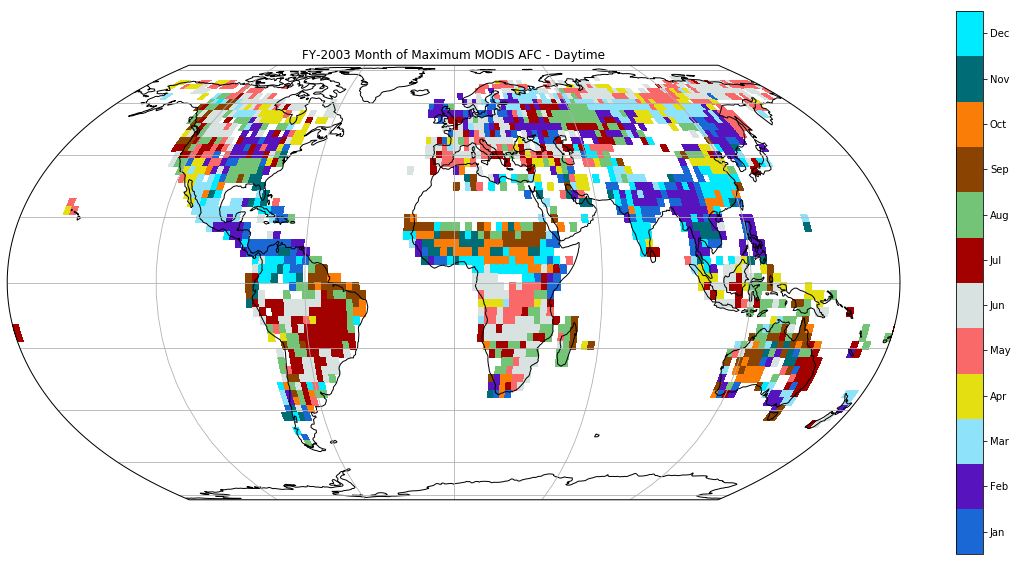

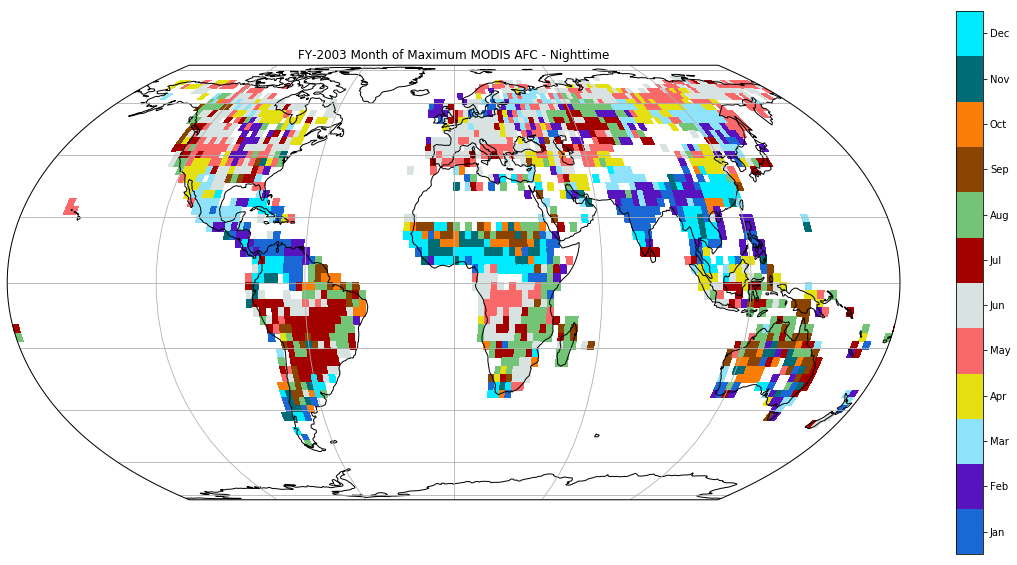

*************************************************************************


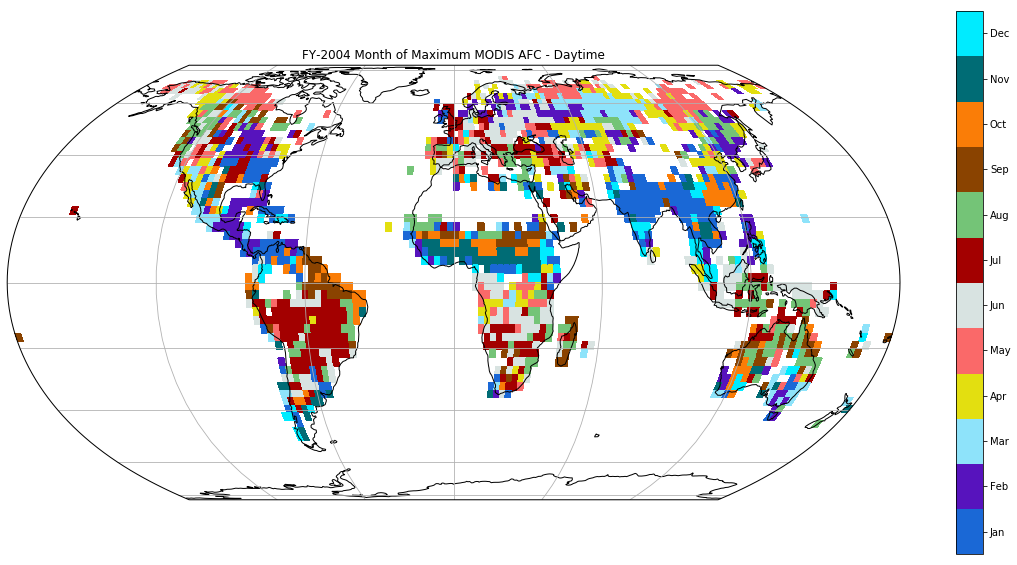

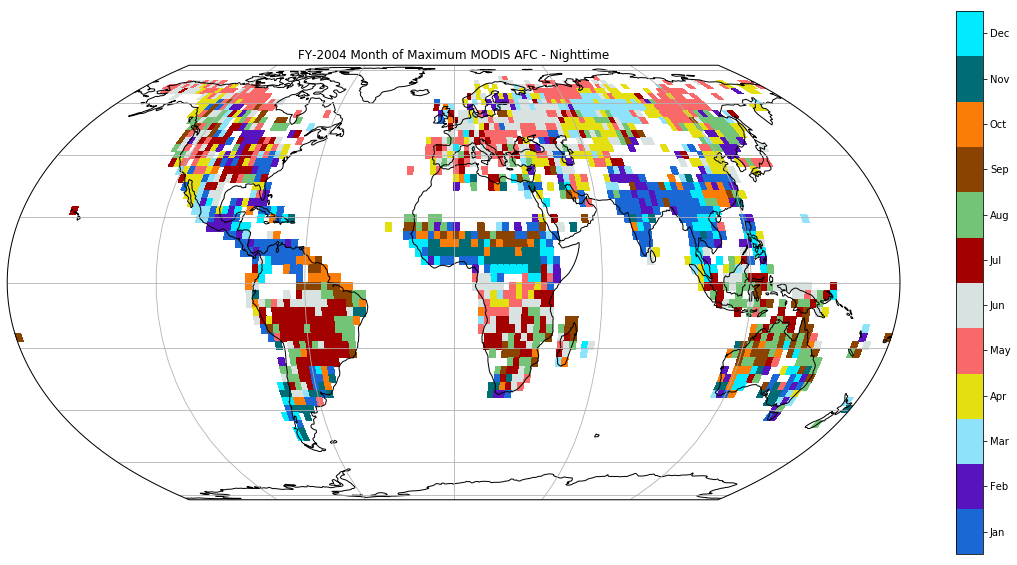

*************************************************************************


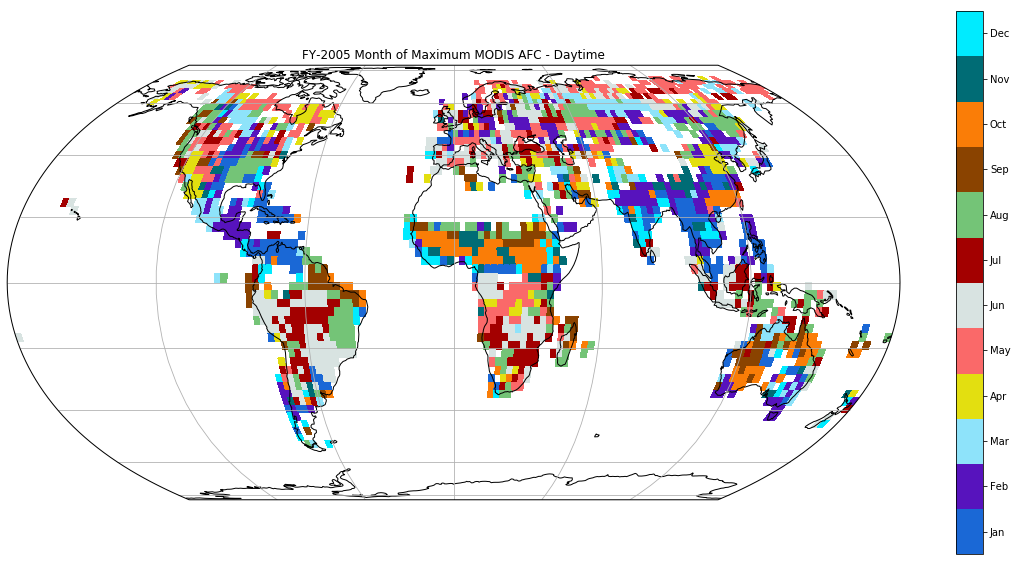

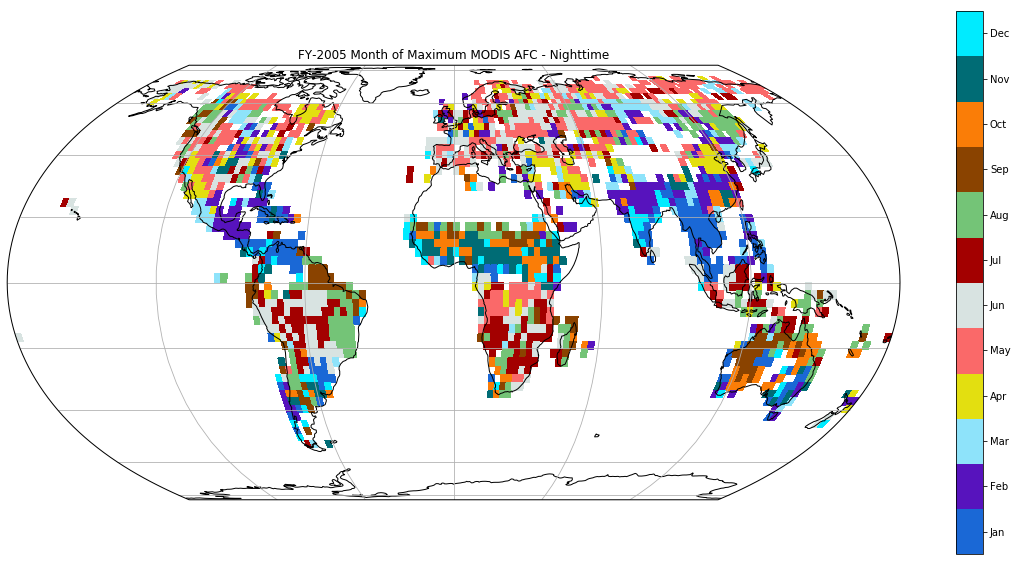

*************************************************************************


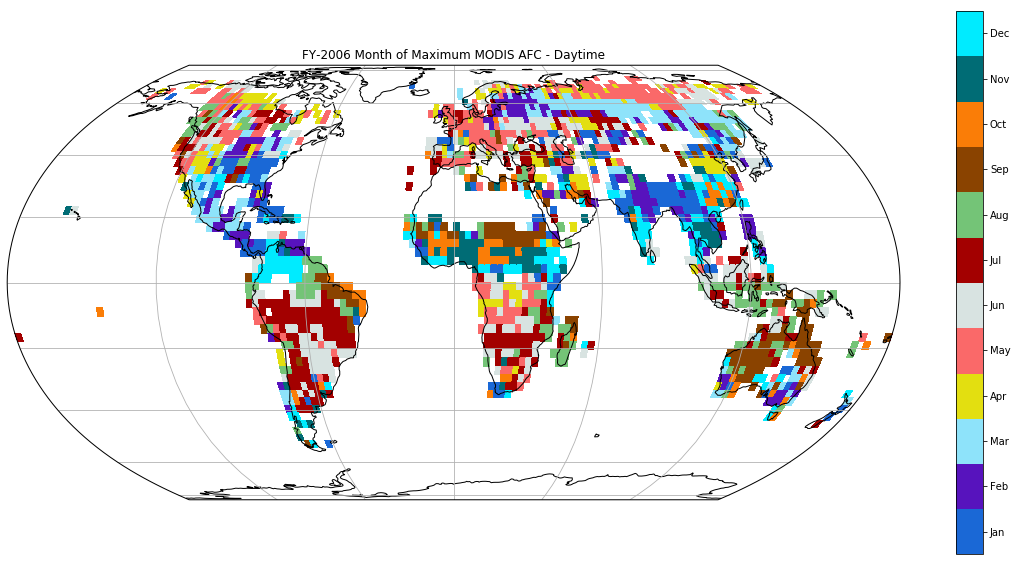

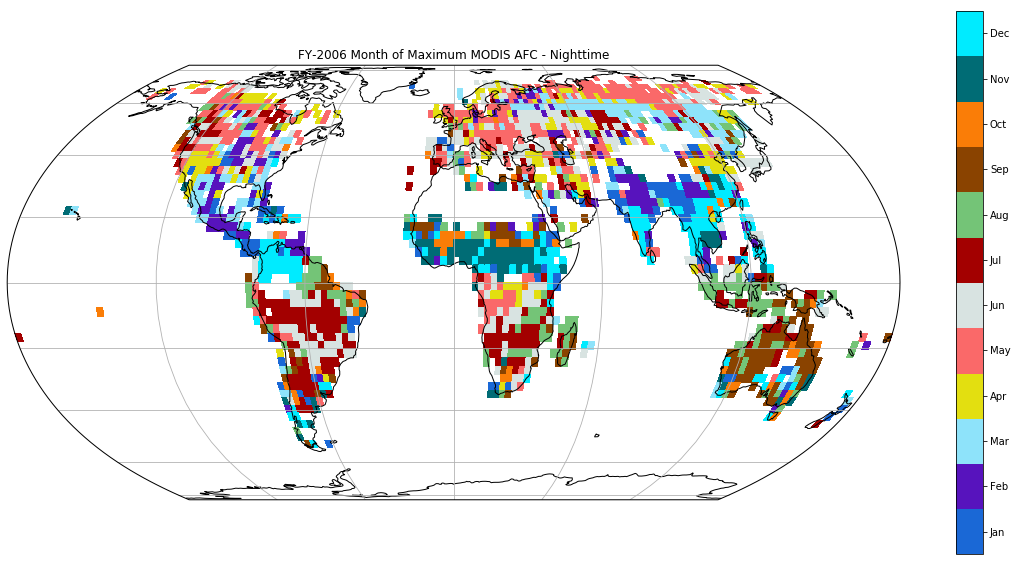

*************************************************************************


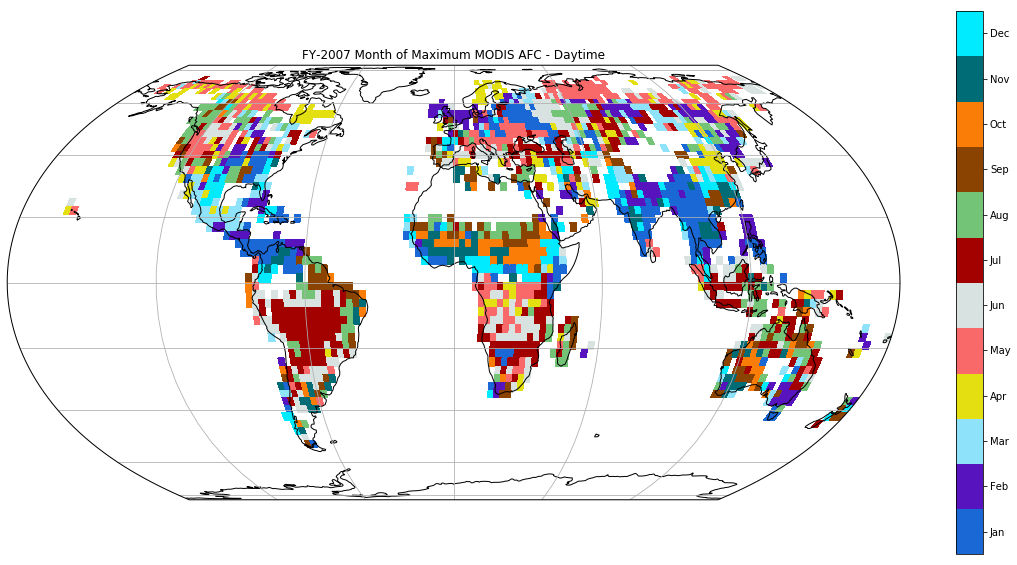

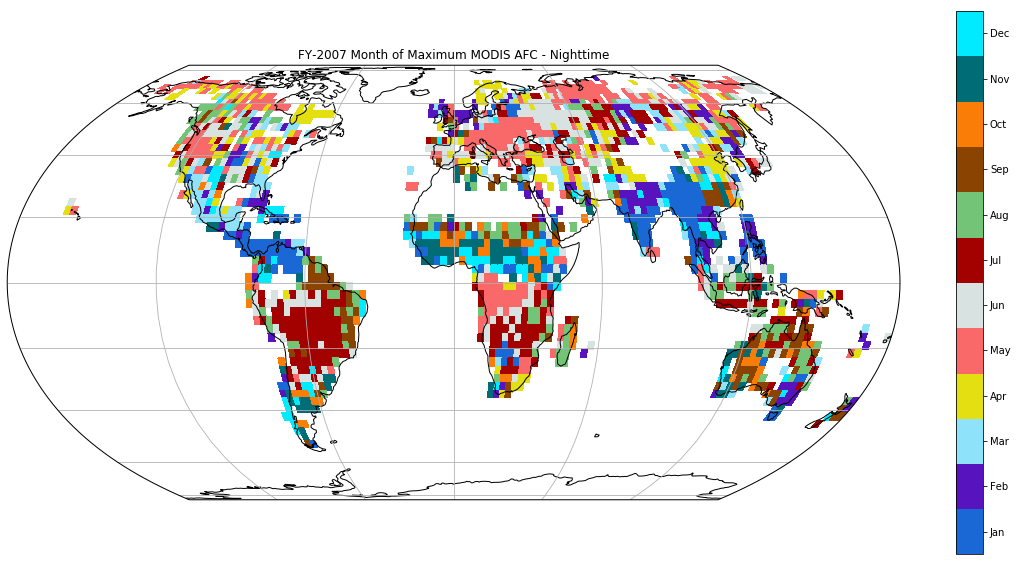

*************************************************************************


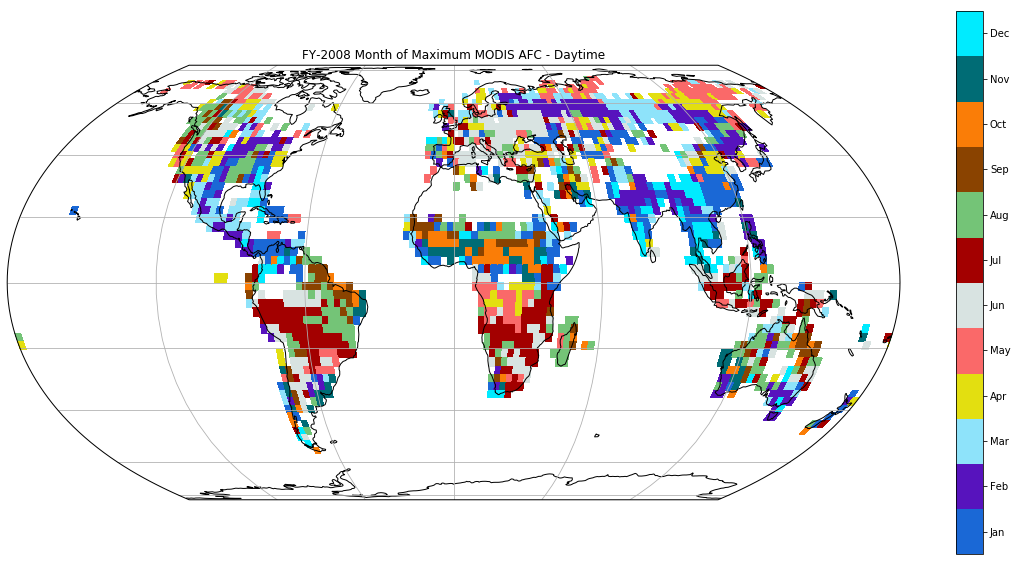

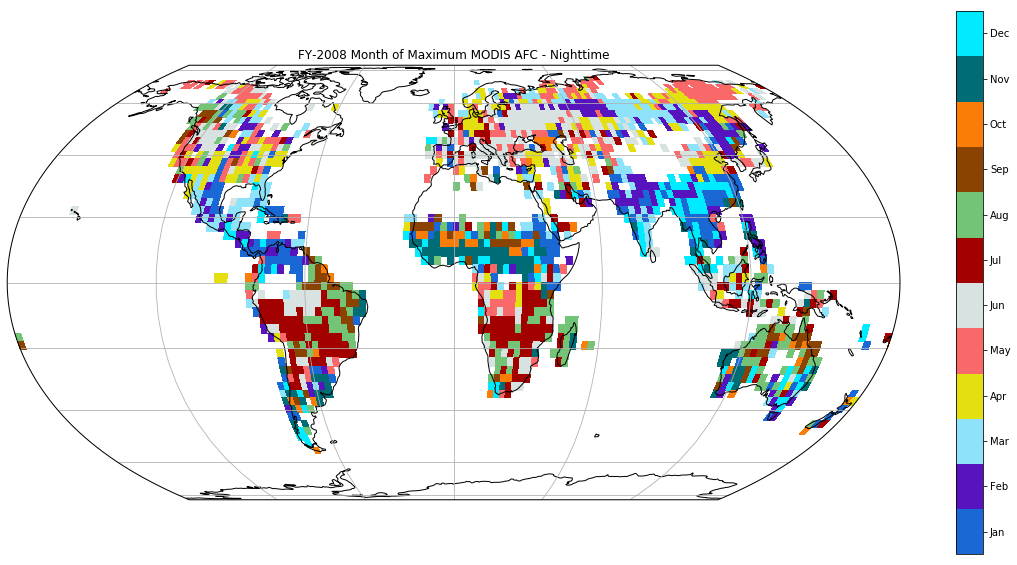

*************************************************************************


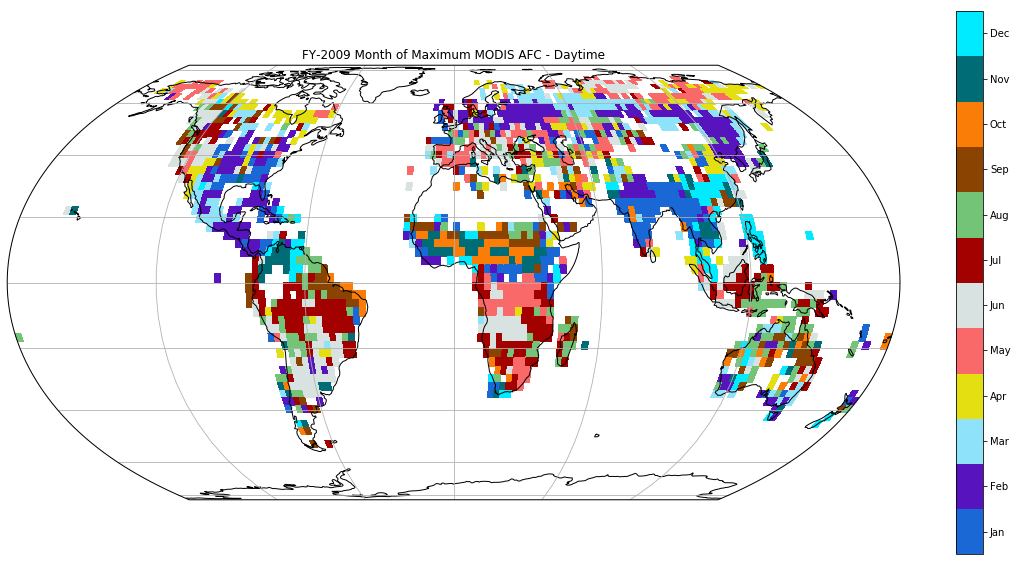

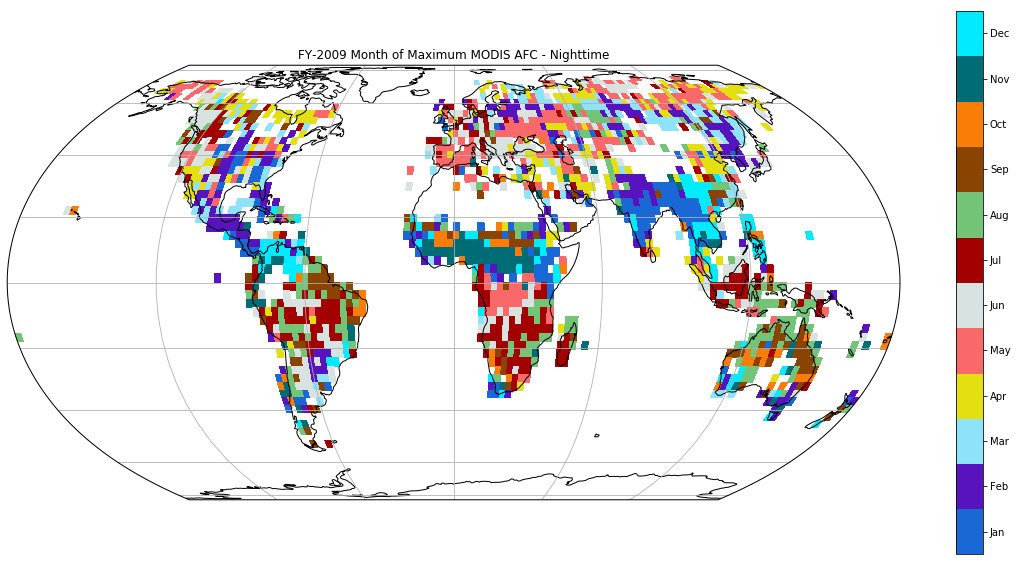

*************************************************************************


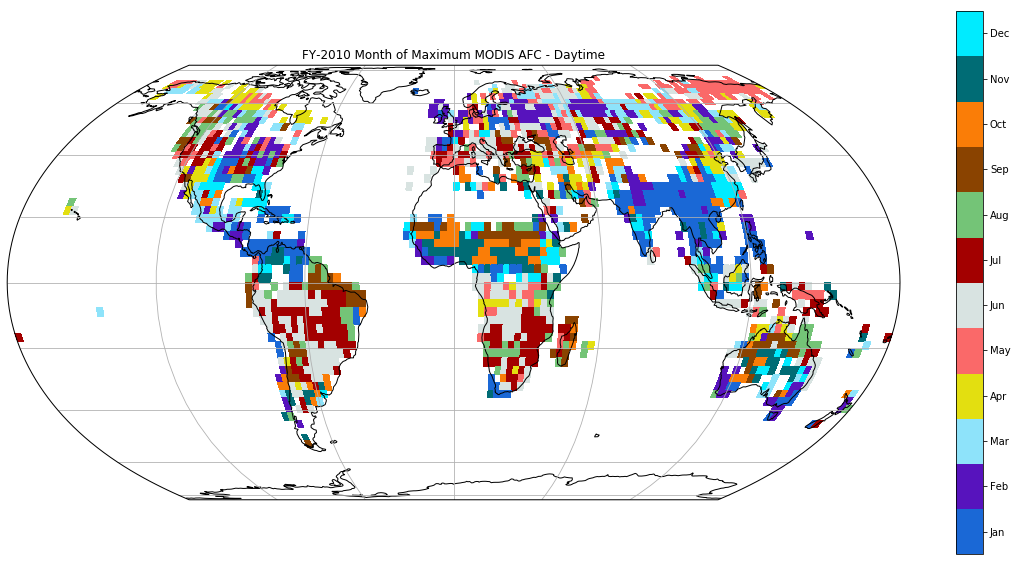

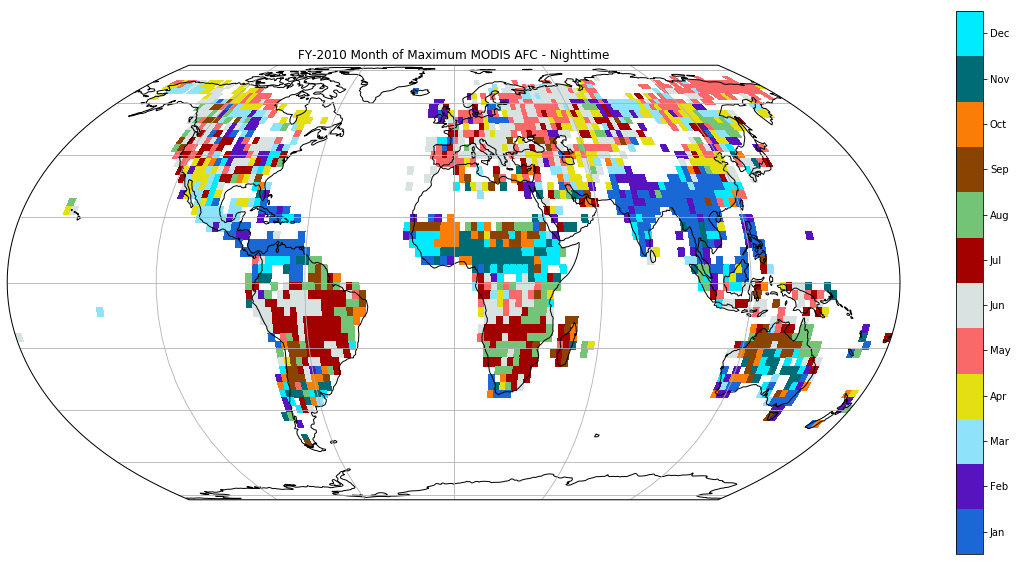

*************************************************************************


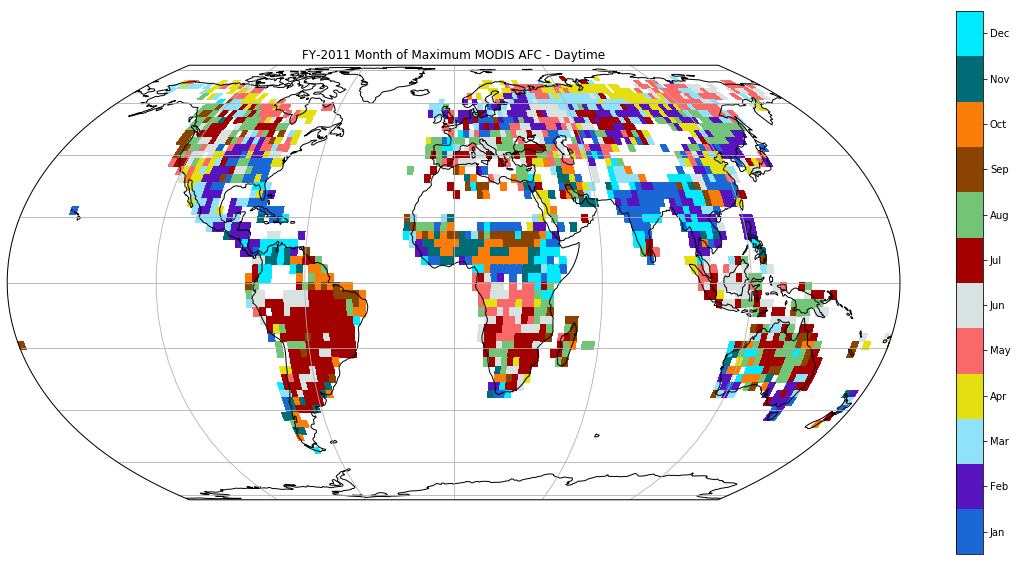

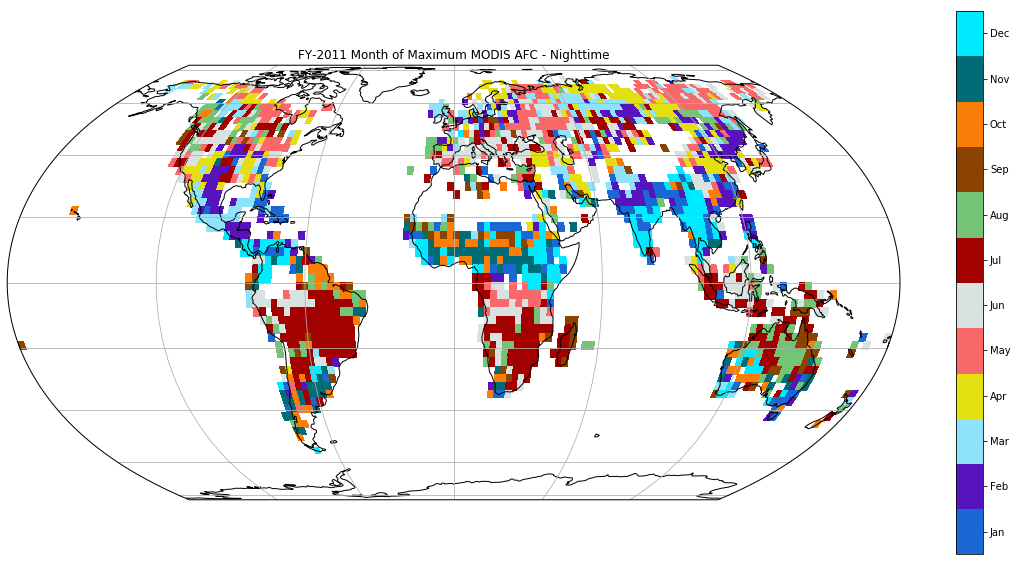

*************************************************************************


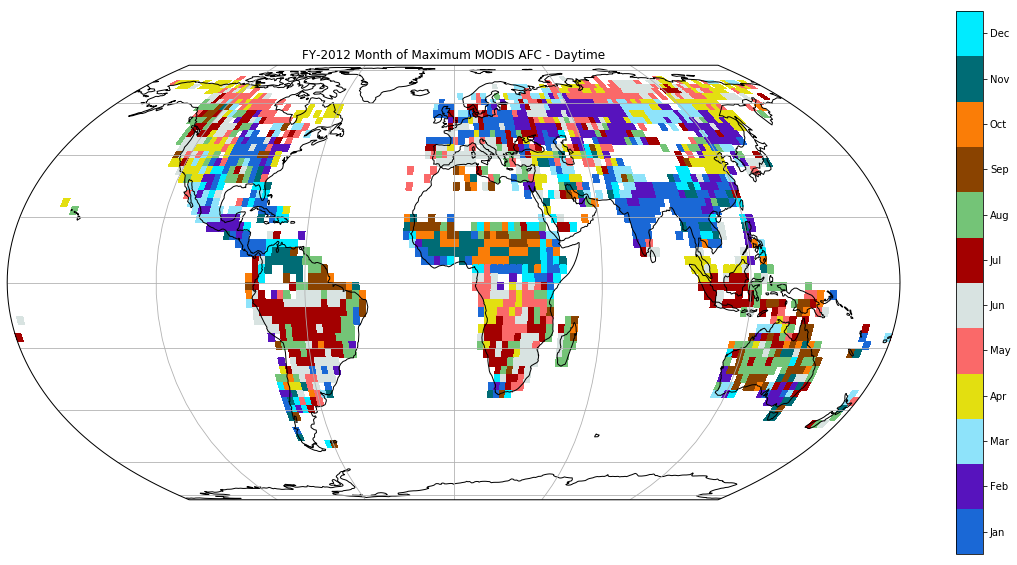

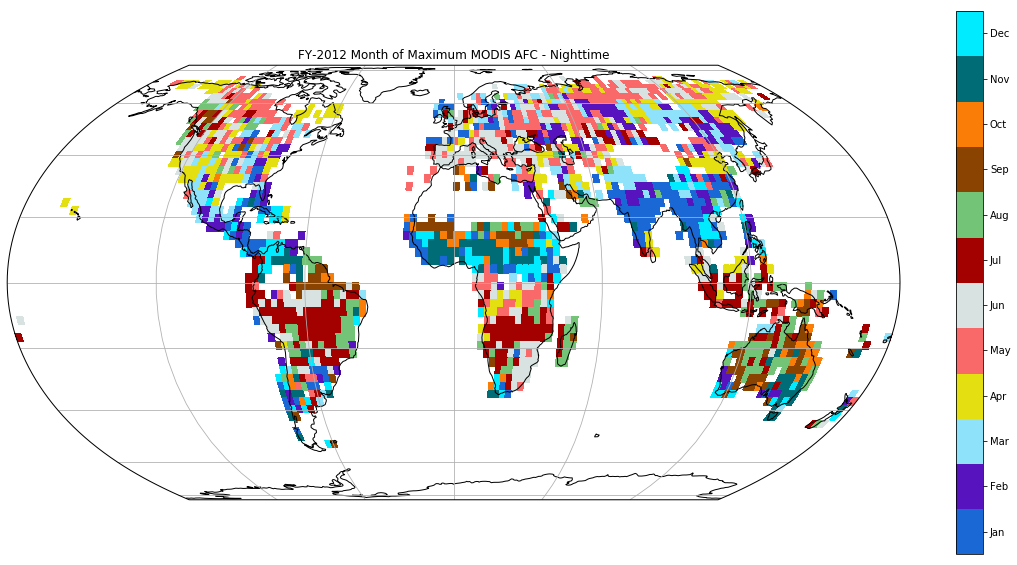

*************************************************************************


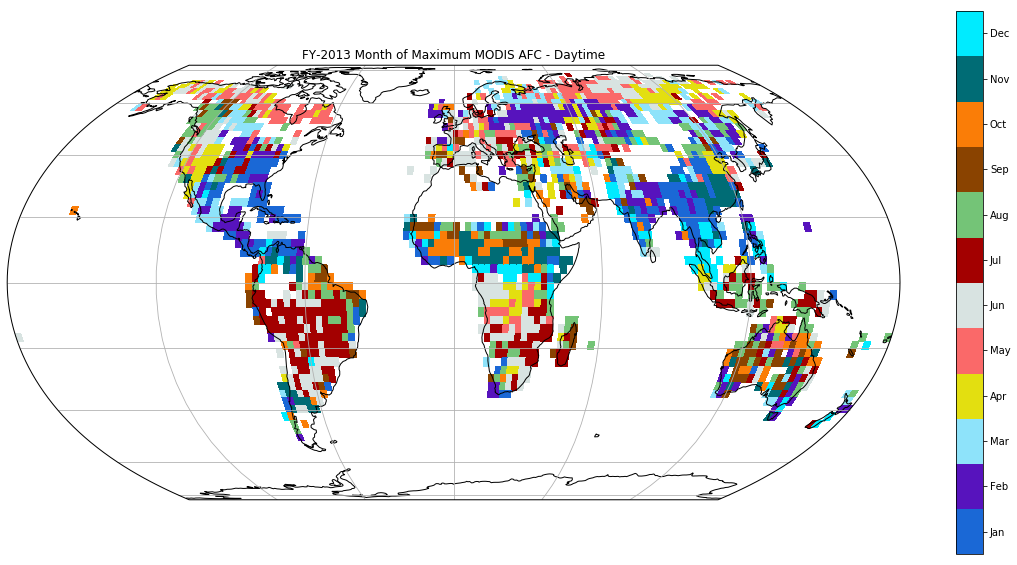

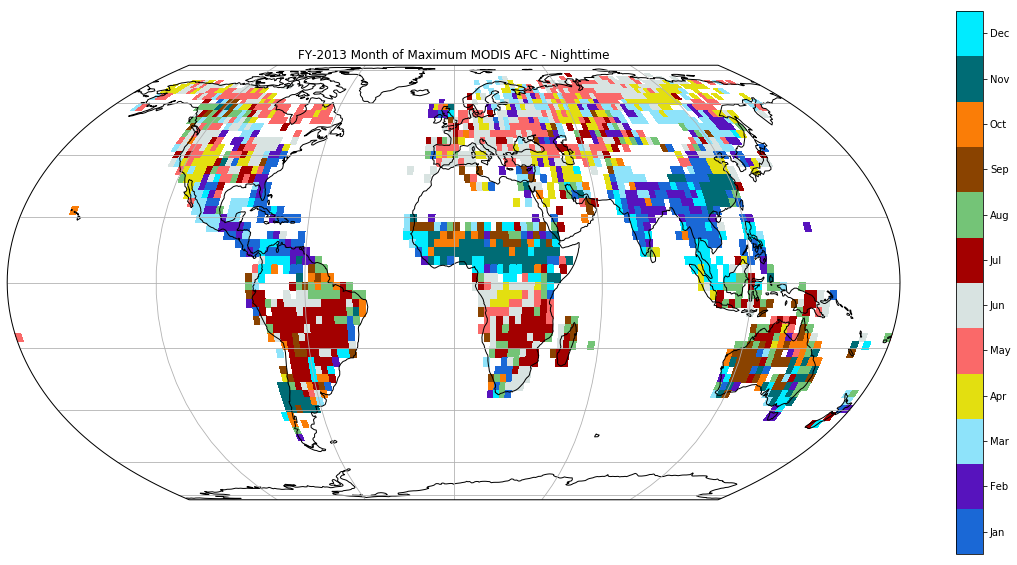

*************************************************************************


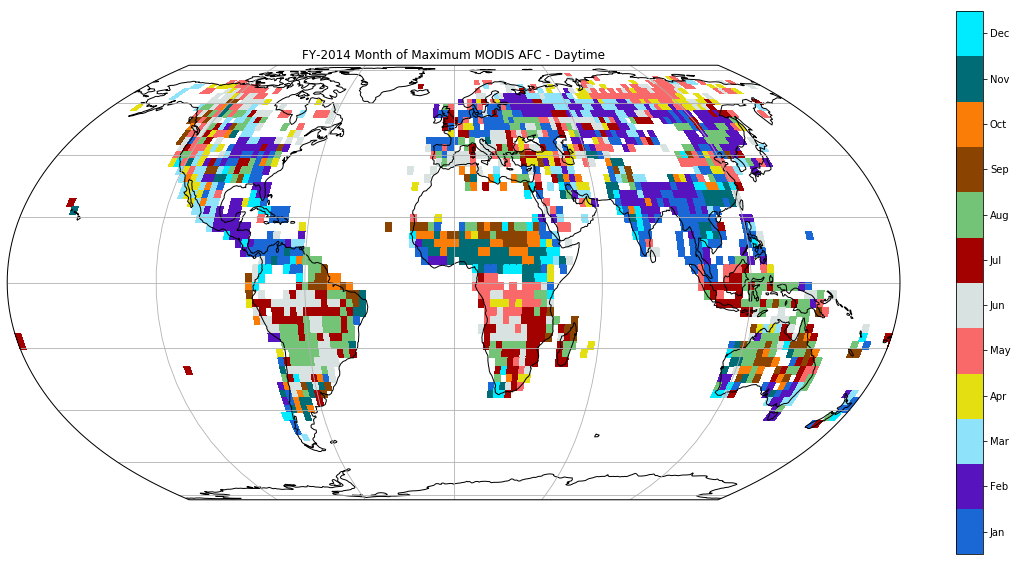

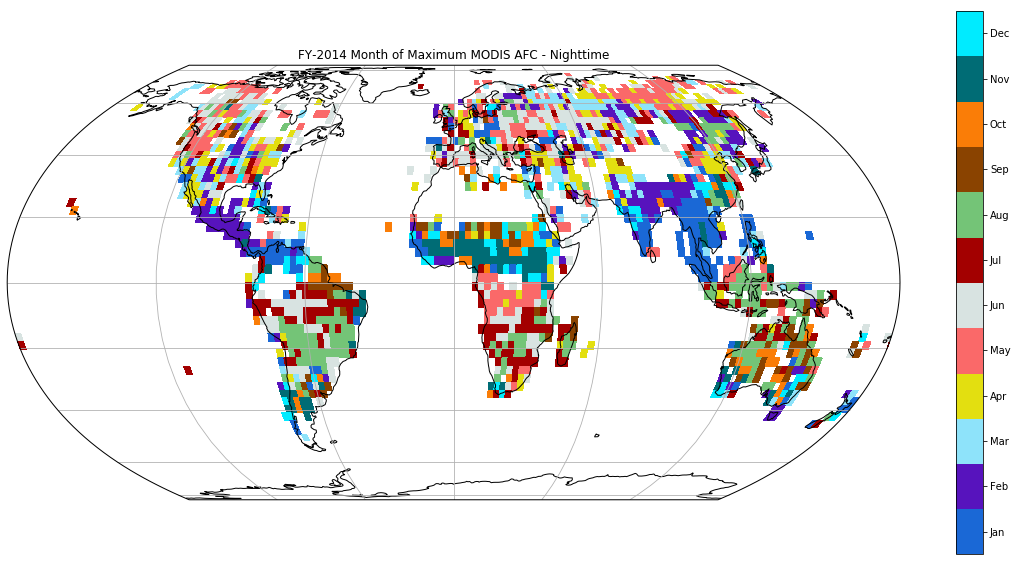

*************************************************************************


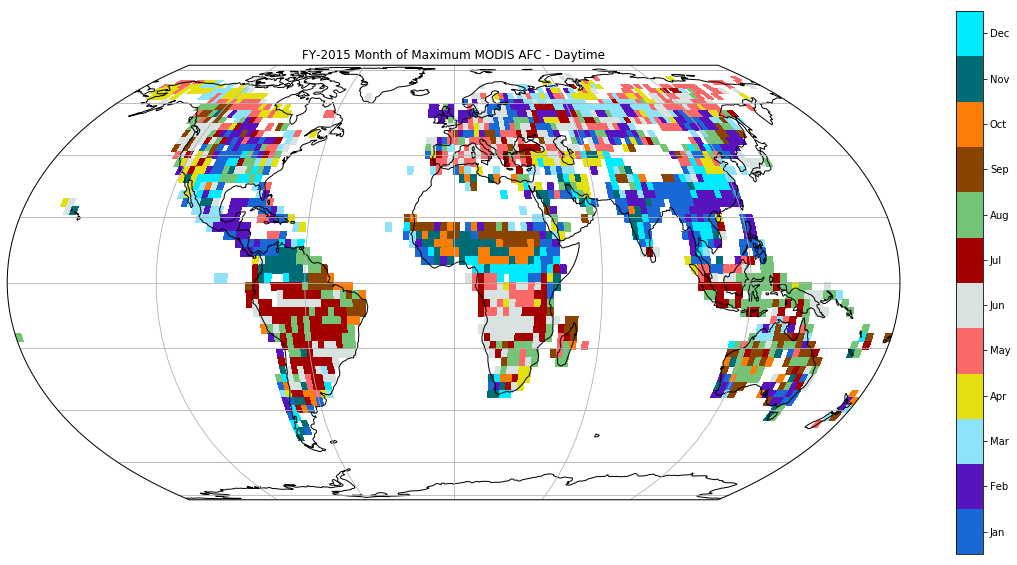

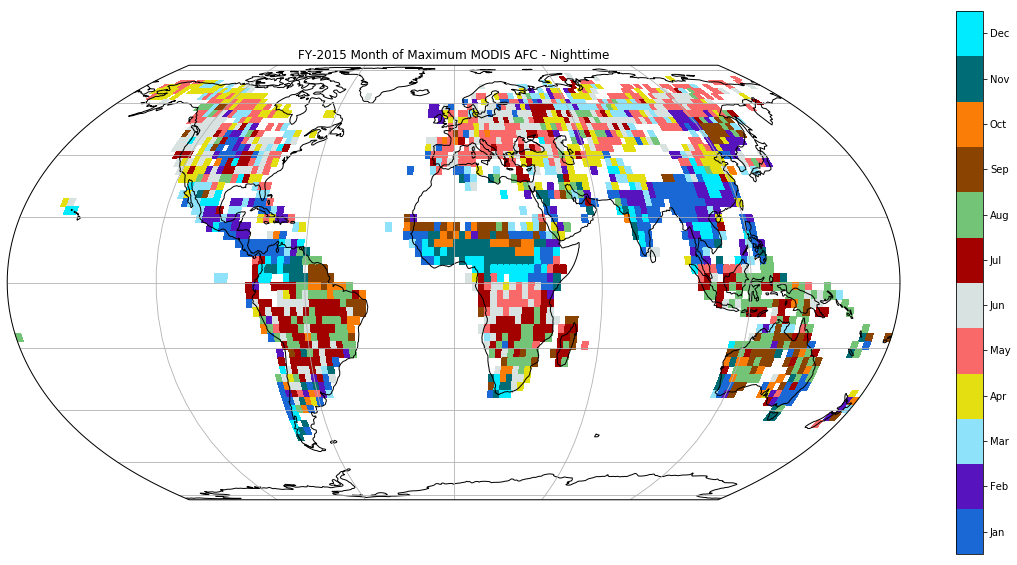

*************************************************************************


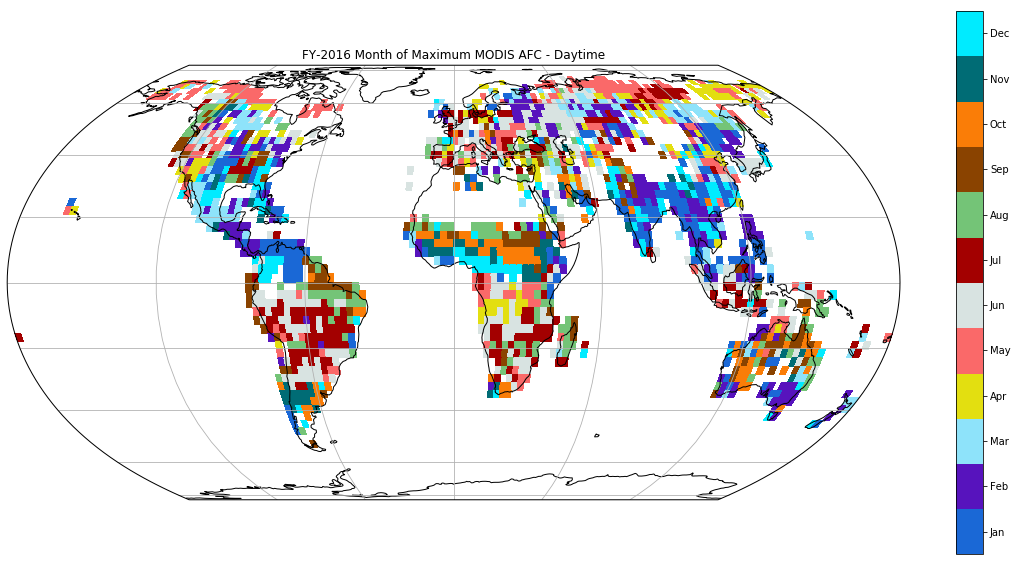

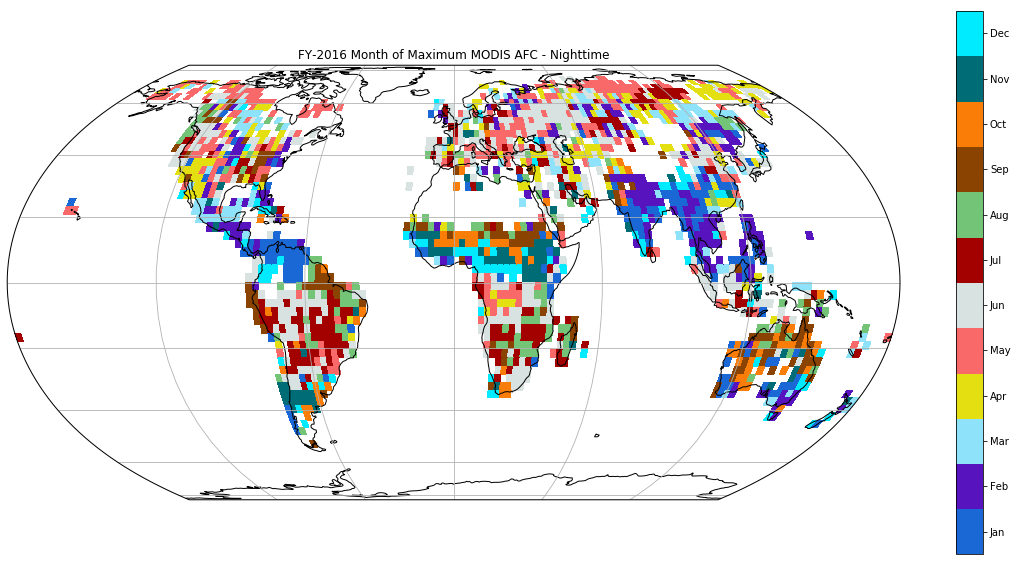

*************************************************************************


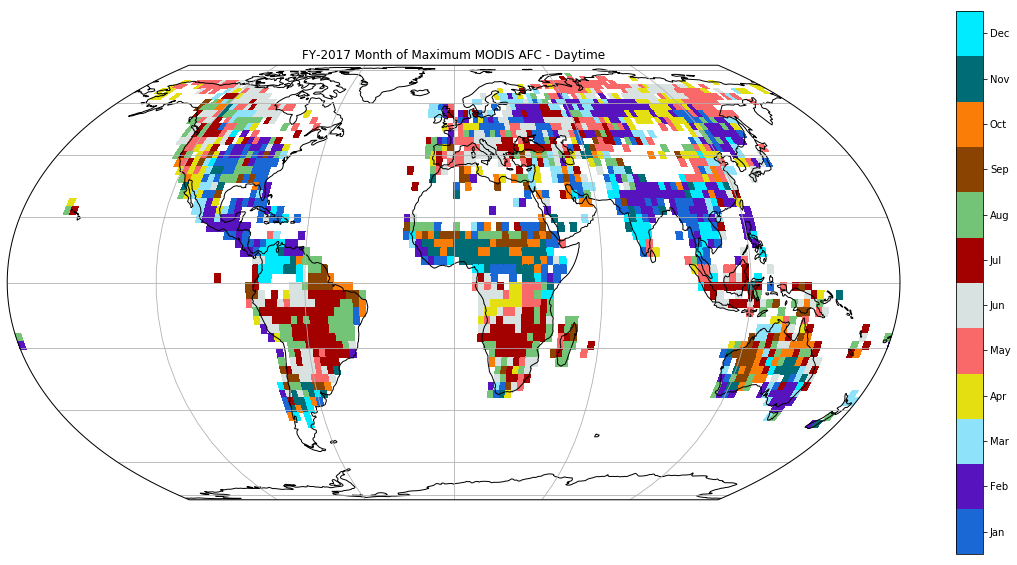

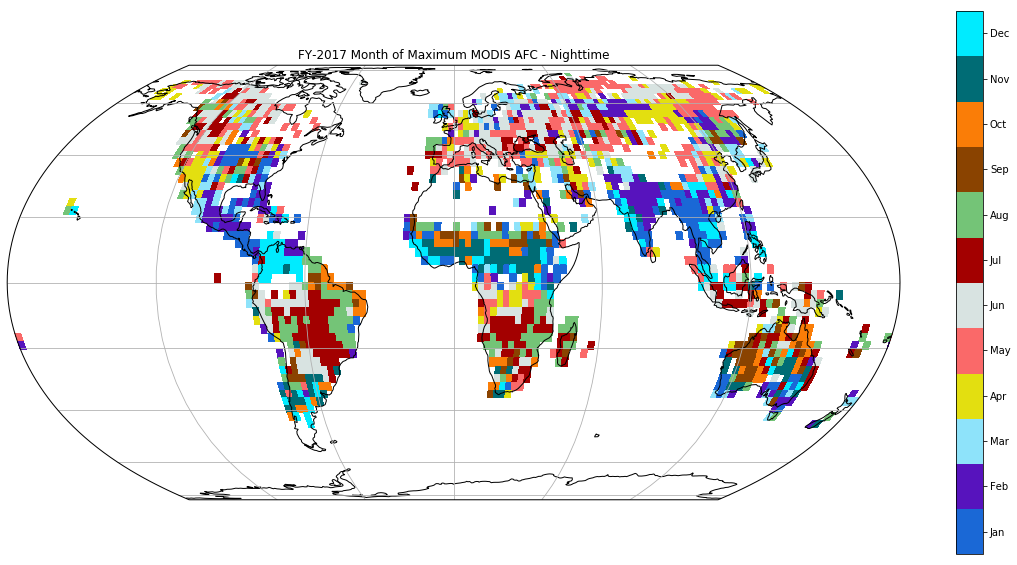

*************************************************************************


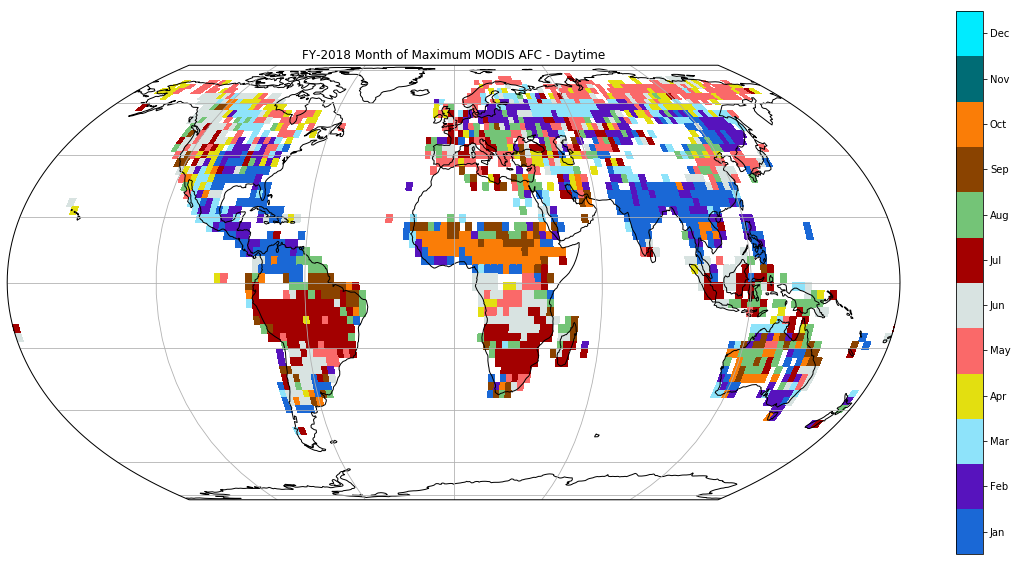

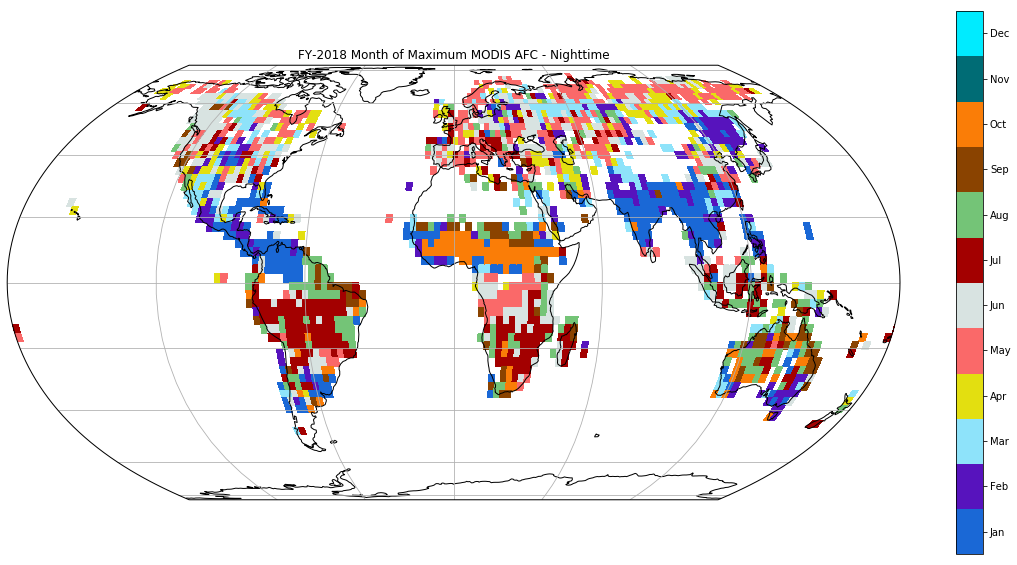

*************************************************************************


In [46]:
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]

days, nights=[],[]
day_an, night_an = [],[]
for year in range(2003,2019):

    day_files, night_files = get_fire_year_files(raster_folder, var, year)

    day_argmax = nanargmax(day_files)
    night_argmax = nanargmax(night_files)
    
    days.append(day_argmax)
    nights.append(night_argmax)


    day_title = 'FY-{} Month of Maximum MODIS AFC - Daytime'.format(year)
    day_an.append(plot_max_month(day_argmax, raster_folder, day_title))
    
    night_title = 'FY-{} Month of Maximum MODIS AFC - Nighttime'.format(year)
    night_an.append(plot_max_month(night_argmax, raster_folder, night_title))
    
    print('*************************************************************************')

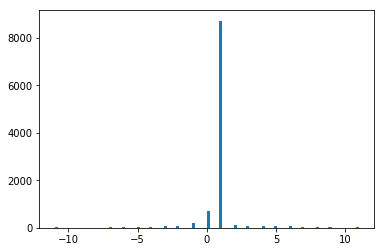

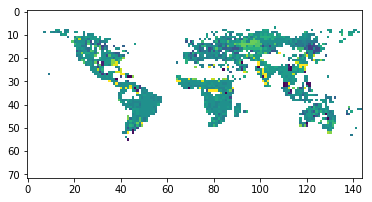

In [48]:
# sanity check that they aren't all the same
ind=0
plt.hist(days[ind].flatten() - days[ind+4].flatten(), bins=100);
plt.show()
plt.imshow(days[ind] - days[ind+1]);

In [47]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./peak_month_night.gif', night_an, fps=1)
imageio.mimsave('./peak_month_day.gif', day_an, fps=1)